# 📑   Deep Learning. P2: Multi-Label Classification. Letter Generator
## ✒️ &nbsp; Importing Libraries and Defining Helpful Functions

In [97]:
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [98]:
import h5py,urllib,zipfile
import pandas as pd,numpy as np,pylab as pl
import keras as ks,tensorflow as tf
import warnings; warnings.filterwarnings('ignore')
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import Adam,Nadam
from keras.models import Sequential,load_model,Model
from keras.layers import Input,Activation,Dense,LSTM
from keras.layers import Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU,LeakyReLU
i0,i1,i2,i3,i4,i5,i6,i7,i8=\
int(0),int(1),int(2),int(3),int(4),int(5),int(6),int(7),int(8)
i32,i128,i255,i1024=int(32),int(128),int(255),int(1024)
np.set_printoptions(precision=8); il=10**2
from keras import __version__
print('keras version:',__version__)
print('tensorflow version:',tf.__version__)

keras version: 2.2.5
tensorflow version: 1.15.2


In [0]:
def preprocess(x):    
    x=(x-.5)*2
    return np.clip(x,-i1,i1)
def deprocess(x):
    x=(x/2+.5)*255
#    np.place(x,x>int(220),i255)
    x=np.clip(x,i0,i255)
    x=np.uint8(x)
    return x.reshape(i32,i32)
def latent_samples(n_samples,sample_size):
    return np.random.normal(loc=i0,scale=i1,
                            size=(n_samples,sample_size))
latent_sample1024=latent_samples(i1,i1024)
latent_sample128=latent_samples(i1,i128)
def display_images(generated_images):
    n_images=len(generated_images)
    rows=i4; cols=n_images//rows    
    pl.figure(figsize=(cols,rows))
    for i in range(n_images):
        img=deprocess(generated_images[i])
        pl.subplot(rows,cols,i+i1)
        pl.imshow(img,cmap=pl.cm.Greys)
        pl.xticks([]); pl.yticks([])
    pl.tight_layout(); pl.show()

## ✒️ &nbsp; Loading & Preprocessing the Data

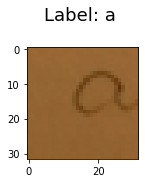

In [100]:
fpath='https://olgabelitskaya.github.io/'
zf='LetterColorImages2.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb')
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys())
letters=u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
images=np.array(f[keys[1]])/255
labels=np.array(f[keys[2]])
pl.figure(figsize=(2,3))
pl.title('Label: %s \n'%letters[labels[il]-i1],
         fontsize=18)
pl.imshow(images[il]); pl.show()

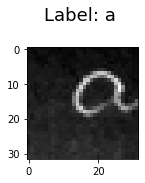

((5000, 1024), dtype('float64'))

In [101]:
gray_images=np.dot(images[...,:3],[.299,.587,.114])
N=int(5000); gray_images=gray_images[:N]
gray_images=gray_images.reshape(-i1,i32*i32)
pl.figure(figsize=(2,3))
pl.title('Label: %s \n'%letters[labels[il]-i1],fontsize=18)
img=np.array(gray_images[il].reshape(32,32))
pl.imshow(img.astype(float),
          cmap=pl.cm.Greys); pl.show()
del images
gray_images.shape,gray_images.dtype

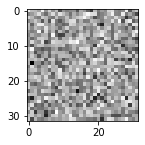

In [102]:
pl.figure(figsize=(2,3))
img0=np.squeeze(latent_sample1024).reshape(i32,i32)
pl.imshow(img0,cmap=pl.cm.Greys); pl.show()

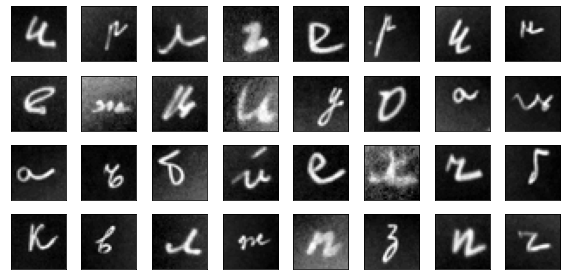

((4500, 1024), (500, 1024))

In [103]:
X_train_real,X_test_real=\
train_test_split(gray_images,test_size=.1)
X_train_real=preprocess(X_train_real)
X_test_real=preprocess(X_test_real)
display_images(X_train_real[:i32])
X_train_real.shape,X_test_real.shape

## ✒️ &nbsp; Keras GAN
[`"Using GAN for Generating Hand-written Digit Images" by Naoki Shibuya`](https://github.com/naokishibuya/deep-learning/blob/master/python/gan_mnist.ipynb)

#### A Simple Example

In [104]:
discriminator=Sequential([Dense(i128,input_shape=(i1024,)),
                          LeakyReLU(alpha=.01),
                          Dense(i1),Activation('sigmoid')], 
                         name='discriminator')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               131200    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 131,329
Trainable params: 131,329
Non-trainable params: 0
_________________________________________________________________


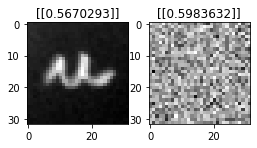

In [105]:
fig=pl.figure(figsize=(4,3))
ax=fig.add_subplot(121)
img=X_train_real[il].reshape(i1,i1024)
ax.set_title(discriminator.predict(img))
ax.imshow(img.reshape(i32,i32),cmap=pl.cm.Greys)
ax=fig.add_subplot(122)
ax.set_title(discriminator.predict(img0.reshape(i1,i1024)))
ax.imshow(img0,cmap=pl.cm.Greys); pl.show()

In [106]:
generator=Sequential([Dense(i1024,input_shape=(i128,)),
                      LeakyReLU(alpha=.01),
                      Dense(i1024),Activation('tanh')], 
                     name='generator')
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1024)              132096    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_4 (Activation)    (None, 1024)              0         
Total params: 1,181,696
Trainable params: 1,181,696
Non-trainable params: 0
_________________________________________________________________


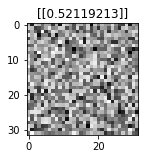

In [107]:
pl.figure(figsize=(2,3))
generated_latent_sample=generator.predict(latent_sample128)
pl.title(discriminator.predict(generated_latent_sample))
pl.imshow(generated_latent_sample.reshape(i32,i32),
           cmap=pl.cm.Greys); pl.show()

In [108]:
gan=Sequential([generator,discriminator])
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 1024)              1181696   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 131329    
Total params: 1,313,025
Trainable params: 1,313,025
Non-trainable params: 0
_________________________________________________________________


#### Building the GAN Model

In [0]:
def trainable(model,trainable):
    for layer in model.layers:
        layer.trainable=trainable
def simple_GAN(sample_size, 
               g_hidden_size, 
               d_hidden_size, 
               leaky_alpha, 
               g_learning_rate,
               d_learning_rate):    
    ks.backend.clear_session()    
    generator=Sequential([Dense(g_hidden_size,input_shape=(sample_size,)),
                          LeakyReLU(alpha=leaky_alpha),
                          Dense(i1024),Activation('tanh')], 
                         name='generator')    
    discriminator=Sequential([Dense(d_hidden_size,input_shape=(i1024,)),
                              LeakyReLU(alpha=leaky_alpha),
                              Dense(i1),Activation('sigmoid')], 
                             name='discriminator')        
    gan=Sequential([generator,discriminator])    
    discriminator.compile(optimizer=Adam(lr=d_learning_rate), 
                          loss='binary_crossentropy')
    gan.compile(optimizer=Adam(lr=g_learning_rate), 
                loss='binary_crossentropy')   
    return gan,generator,discriminator

In [110]:
sample_size    =i128     
g_hidden_size  =i1024  # generator
d_hidden_size  =i128   # discriminator
leaky_alpha    =.02
g_learning_rate=.0001    # generator
d_learning_rate=.0007   # discriminator
epochs         =int(1000)
batch_size     =int(128)      
valid_size     =int(16)     
smooth         =.08
def real_fake_labels(size):
    return np.ones([size,i1]),np.zeros([size,i1])
y_real5,y_fake5=real_fake_labels(5)
print('Real\n',y_real5,'\nFake\n',y_fake5)
y_train_real,y_train_fake=real_fake_labels(batch_size)
y_valid_real,y_valid_fake=real_fake_labels(valid_size)
gan,generator,discriminator=\
simple_GAN(sample_size,g_hidden_size,d_hidden_size,
           leaky_alpha,g_learning_rate,d_learning_rate)

Real
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]] 
Fake
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


Epoch: 10/1000 | Discriminator Loss: 0.0979 | Generator Loss: 5.3949 | DL > GL: False
Epoch: 20/1000 | Discriminator Loss: 0.0903 | Generator Loss: 5.7586 | DL > GL: False
Epoch: 30/1000 | Discriminator Loss: 0.1547 | Generator Loss: 3.7431 | DL > GL: False
Epoch: 40/1000 | Discriminator Loss: 0.5038 | Generator Loss: 1.5289 | DL > GL: False
Epoch: 50/1000 | Discriminator Loss: 0.5540 | Generator Loss: 2.0244 | DL > GL: False
Epoch: 60/1000 | Discriminator Loss: 0.3641 | Generator Loss: 2.0119 | DL > GL: False
Epoch: 70/1000 | Discriminator Loss: 0.7822 | Generator Loss: 2.9764 | DL > GL: False
Epoch: 80/1000 | Discriminator Loss: 0.3057 | Generator Loss: 2.0858 | DL > GL: False
Epoch: 90/1000 | Discriminator Loss: 0.3459 | Generator Loss: 2.1281 | DL > GL: False
Epoch: 100/1000 | Discriminator Loss: 0.4456 | Generator Loss: 2.1632 | DL > GL: False
Epoch: 110/1000 | Discriminator Loss: 0.4168 | Generator Loss: 2.1551 | DL > GL: False
Epoch: 120/1000 | Discriminator Loss: 0.5631 | Gener

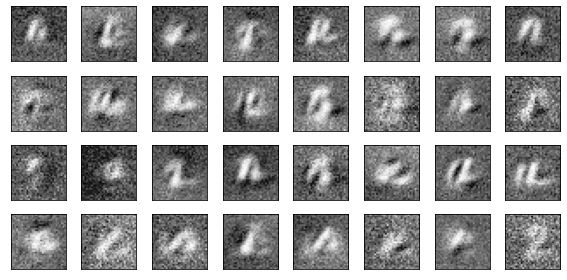

Epoch: 310/1000 | Discriminator Loss: 0.9102 | Generator Loss: 1.3282 | DL > GL: False
Epoch: 320/1000 | Discriminator Loss: 0.8248 | Generator Loss: 1.2905 | DL > GL: False
Epoch: 330/1000 | Discriminator Loss: 1.1435 | Generator Loss: 1.3404 | DL > GL: False
Epoch: 340/1000 | Discriminator Loss: 1.1650 | Generator Loss: 1.2085 | DL > GL: False
Epoch: 350/1000 | Discriminator Loss: 1.2085 | Generator Loss: 0.9166 | DL > GL: True
Epoch: 360/1000 | Discriminator Loss: 1.0586 | Generator Loss: 1.0612 | DL > GL: False
Epoch: 370/1000 | Discriminator Loss: 0.8199 | Generator Loss: 2.0458 | DL > GL: False
Epoch: 380/1000 | Discriminator Loss: 0.4611 | Generator Loss: 2.3208 | DL > GL: False
Epoch: 390/1000 | Discriminator Loss: 0.9710 | Generator Loss: 1.5380 | DL > GL: False
Epoch: 400/1000 | Discriminator Loss: 0.9169 | Generator Loss: 1.5173 | DL > GL: False
Epoch: 410/1000 | Discriminator Loss: 1.1812 | Generator Loss: 1.2917 | DL > GL: False
Epoch: 420/1000 | Discriminator Loss: 0.6715

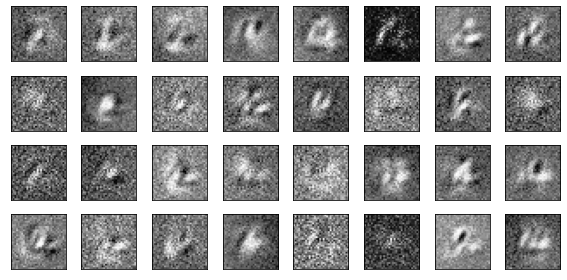

Epoch: 500/1000 | Discriminator Loss: 0.8809 | Generator Loss: 1.2244 | DL > GL: False
Epoch: 510/1000 | Discriminator Loss: 0.7444 | Generator Loss: 1.4089 | DL > GL: False
Epoch: 520/1000 | Discriminator Loss: 0.8123 | Generator Loss: 1.4295 | DL > GL: False
Epoch: 530/1000 | Discriminator Loss: 0.8431 | Generator Loss: 1.4142 | DL > GL: False
Epoch: 540/1000 | Discriminator Loss: 0.9794 | Generator Loss: 1.2767 | DL > GL: False
Epoch: 550/1000 | Discriminator Loss: 1.0072 | Generator Loss: 2.0077 | DL > GL: False
Epoch: 560/1000 | Discriminator Loss: 0.8650 | Generator Loss: 1.1983 | DL > GL: False
Epoch: 570/1000 | Discriminator Loss: 1.0103 | Generator Loss: 1.4801 | DL > GL: False
Epoch: 580/1000 | Discriminator Loss: 0.7800 | Generator Loss: 1.2810 | DL > GL: False
Epoch: 590/1000 | Discriminator Loss: 0.9876 | Generator Loss: 1.5371 | DL > GL: False
Epoch: 600/1000 | Discriminator Loss: 0.9934 | Generator Loss: 1.3778 | DL > GL: False
Epoch: 610/1000 | Discriminator Loss: 0.725

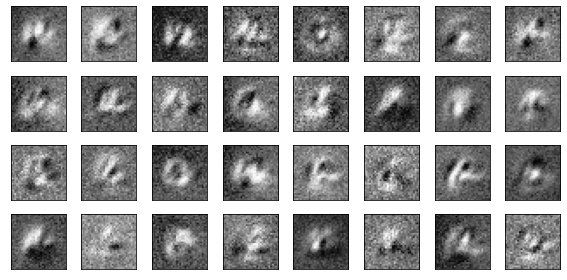

Epoch: 630/1000 | Discriminator Loss: 1.0904 | Generator Loss: 1.2804 | DL > GL: False
Epoch: 640/1000 | Discriminator Loss: 1.1556 | Generator Loss: 0.9416 | DL > GL: True
Epoch: 650/1000 | Discriminator Loss: 1.1174 | Generator Loss: 0.9036 | DL > GL: True
Epoch: 660/1000 | Discriminator Loss: 0.8768 | Generator Loss: 1.2747 | DL > GL: False
Epoch: 670/1000 | Discriminator Loss: 1.2744 | Generator Loss: 0.9532 | DL > GL: True
Epoch: 680/1000 | Discriminator Loss: 1.3371 | Generator Loss: 0.9630 | DL > GL: True
Epoch: 690/1000 | Discriminator Loss: 0.6788 | Generator Loss: 1.7241 | DL > GL: False
Epoch: 700/1000 | Discriminator Loss: 0.8994 | Generator Loss: 1.7685 | DL > GL: False
Epoch: 710/1000 | Discriminator Loss: 1.2964 | Generator Loss: 0.9042 | DL > GL: True
Epoch: 720/1000 | Discriminator Loss: 0.8857 | Generator Loss: 1.0233 | DL > GL: False
Epoch: 730/1000 | Discriminator Loss: 0.9554 | Generator Loss: 1.0884 | DL > GL: False
Epoch: 740/1000 | Discriminator Loss: 1.4064 | G

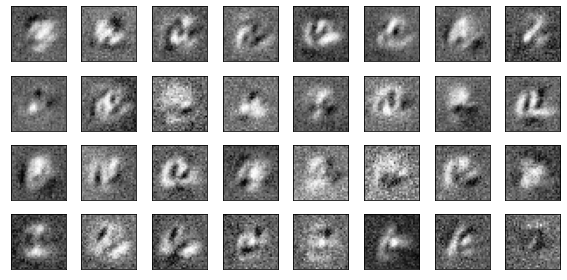

Epoch: 750/1000 | Discriminator Loss: 1.4442 | Generator Loss: 0.9409 | DL > GL: True
Epoch: 760/1000 | Discriminator Loss: 0.9424 | Generator Loss: 1.3757 | DL > GL: False
Epoch: 770/1000 | Discriminator Loss: 1.1958 | Generator Loss: 1.4990 | DL > GL: False
Epoch: 780/1000 | Discriminator Loss: 0.9212 | Generator Loss: 1.1789 | DL > GL: False
Epoch: 790/1000 | Discriminator Loss: 0.9316 | Generator Loss: 0.9965 | DL > GL: False
Epoch: 800/1000 | Discriminator Loss: 1.4071 | Generator Loss: 0.8240 | DL > GL: True


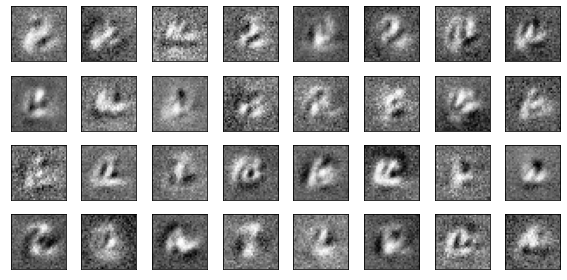

Epoch: 810/1000 | Discriminator Loss: 0.5634 | Generator Loss: 1.6973 | DL > GL: False
Epoch: 820/1000 | Discriminator Loss: 0.8494 | Generator Loss: 1.3322 | DL > GL: False
Epoch: 830/1000 | Discriminator Loss: 0.9432 | Generator Loss: 1.3010 | DL > GL: False
Epoch: 840/1000 | Discriminator Loss: 0.6552 | Generator Loss: 1.4919 | DL > GL: False
Epoch: 850/1000 | Discriminator Loss: 1.2243 | Generator Loss: 1.0931 | DL > GL: True
Epoch: 860/1000 | Discriminator Loss: 0.7215 | Generator Loss: 1.5594 | DL > GL: False
Epoch: 870/1000 | Discriminator Loss: 1.0665 | Generator Loss: 1.1835 | DL > GL: False
Epoch: 880/1000 | Discriminator Loss: 0.7532 | Generator Loss: 1.6999 | DL > GL: False
Epoch: 890/1000 | Discriminator Loss: 1.2121 | Generator Loss: 0.7899 | DL > GL: True


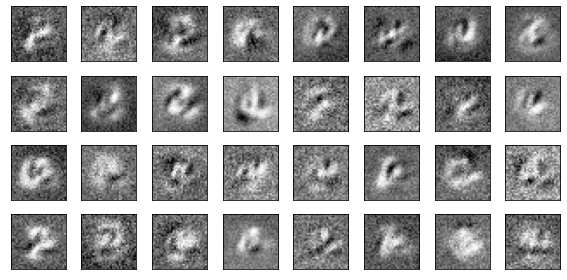

Epoch: 900/1000 | Discriminator Loss: 0.9850 | Generator Loss: 1.4264 | DL > GL: False
Epoch: 910/1000 | Discriminator Loss: 0.6648 | Generator Loss: 1.8095 | DL > GL: False
Epoch: 920/1000 | Discriminator Loss: 0.5418 | Generator Loss: 2.4847 | DL > GL: False
Epoch: 930/1000 | Discriminator Loss: 1.2603 | Generator Loss: 1.2720 | DL > GL: False
Epoch: 940/1000 | Discriminator Loss: 0.9913 | Generator Loss: 1.1825 | DL > GL: False
Epoch: 950/1000 | Discriminator Loss: 1.3733 | Generator Loss: 0.8186 | DL > GL: True


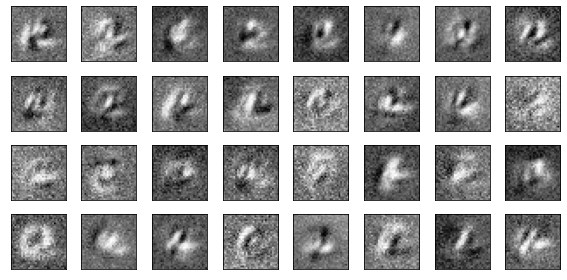

Epoch: 960/1000 | Discriminator Loss: 1.2467 | Generator Loss: 1.6281 | DL > GL: False
Epoch: 970/1000 | Discriminator Loss: 1.0694 | Generator Loss: 1.2281 | DL > GL: False
Epoch: 980/1000 | Discriminator Loss: 1.5075 | Generator Loss: 0.7519 | DL > GL: True


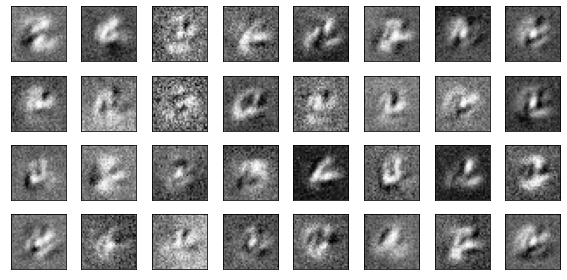

Epoch: 990/1000 | Discriminator Loss: 0.9109 | Generator Loss: 1.2899 | DL > GL: False
Epoch: 1000/1000 | Discriminator Loss: 0.8747 | Generator Loss: 1.2040 | DL > GL: False


In [111]:
losses=[]
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real images
        X_batch_real=X_train_real[i*batch_size:(i+1)*batch_size]        
        # latent samples and generated letter images
        batch_latent_samples=latent_samples(batch_size,sample_size)
        X_batch_fake=generator.predict_on_batch(batch_latent_samples)        
        # train the discriminator to detect real and fake images
        trainable(discriminator,True)
        discriminator.train_on_batch(X_batch_real,y_train_real*(1.-smooth))
        discriminator.train_on_batch(X_batch_fake,y_train_fake)
        # train the generator via GAN
        trainable(discriminator,False)
        gan.train_on_batch(batch_latent_samples,y_train_real)    
    # evaluate
    X_valid_real=X_test_real[np.random.choice(len(X_test_real), 
                                              valid_size,replace=False)]    
    valid_latent_samples=latent_samples(valid_size,sample_size)
    X_valid_fake=generator.predict_on_batch(valid_latent_samples)
    d_loss=discriminator.test_on_batch(X_valid_real,y_valid_real)
    d_loss+=discriminator.test_on_batch(X_valid_fake,y_valid_fake)
    g_loss=gan.test_on_batch(valid_latent_samples,y_valid_real)     
    losses.append((d_loss,g_loss))
    st="Epoch: %d/%d | Discriminator Loss: %.4f | "+\
       "Generator Loss: %.4f | DL > GL: %s"
    if (e+i1)%int(10)==i0:
        print(st%((e+i1,epochs,d_loss,g_loss,d_loss>g_loss)))
        if ((g_loss<.9) and (d_loss>g_loss)):
            latent_examples=latent_samples(i32,sample_size)
            generated_letters=generator.predict(latent_examples)
            display_images(generated_letters)

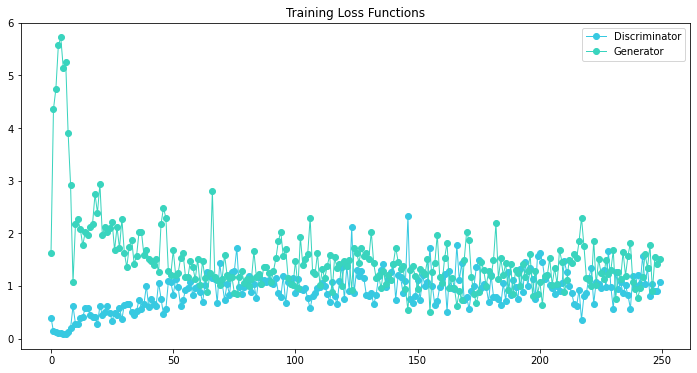

In [112]:
def display_loss(losses,n):
    indices=[i*n for i in range(len(losses)//n)]
    n_losses=np.array(losses)[indices,:]    
    pl.figure(figsize=(12,6))
    pl.plot(n_losses.T[i0],'-o',c='#37c9e1',lw=i1,
            label='Discriminator')
    pl.plot(n_losses.T[1],'-o',c='#39d4be',lw=i1,
            label='Generator')
    pl.title("Training Loss Functions")
    pl.legend(); pl.show()
display_loss(losses,i4)